### IMPORTS

In [1]:
from Inference import BBVI 

In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses

In [3]:
class MeanFieldVariationalDistribution(nn.Module):
    def __init__(self, nb_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(MeanFieldVariationalDistribution, self).__init__()
        self.device = device
        self.nb_dim = nb_dim
        self.mu = nn.Parameter(torch.Tensor(nb_dim).to(self.device), requires_grad=True)
        self.rho = nn.Parameter(torch.Tensor(nb_dim).to(self.device), requires_grad=True)
        
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu)
            
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma)
        
        rho = torch.log(torch.exp(sigma) - 1)
        
        nn.init.constant_(self.mu, mu)
        nn.init.constant_(self.rho, rho)
        
    def set_mu(self, mu):
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu).float()
        nn.init.constant_(self.mu, mu)
        
        
    def set_rho(self, rho):
        if not torch.is_tensor(rho):
            rho = torch.tensor(rho).float()
        nn.init.constant_(self.rho, rho)
       
    def set_sigma(self, sigma):
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma).float()
        rho = self._sigma_to_rho(sigma)
        self.set_rho(rho)
        
    @property
    def sigma(self):
        return self._rho_to_sigma(self.rho)
        
    def sample(self, n=1):
        sigma = self._rho_to_sigma(self.rho)
        epsilon = torch.randn(size=(n,self.nb_dim)).to(self.device)
        return epsilon.mul(sigma).add(self.mu)
    
    def _rho_to_sigma(self, rho):
        sigma = torch.log(1 + torch.exp(rho))
        return sigma

    def _sigma_to_rho(self, sigma):
        rho = torch.log(torch.exp(sigma) - 1)
        return rho
    
    def log_prob(self, z):
        S = torch.diag(self.sigma)
        return torch.distributions.multivariate_normal.MultivariateNormal(self.mu, scale_tril=S).log_prob(z).unsqueeze(-1)

In [4]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [5]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [6]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [8]:
Net = BBVI.VariationalNetwork(input_size=1, output_size=1, layer_width=25, nb_layers=4, device=device)

In [9]:
param_count = int(Net.count_parameters()/2)
q = MeanFieldVariationalDistribution(param_count, sigma=0.0001, device=device)
prior = MeanFieldVariationalDistribution(param_count, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False
q.rho.requires_grad = False
q.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 

In [10]:
def logprior(x):
    return prior.log_prob(x)

In [11]:
def loglikelihood(x):
    Net.set_parameters(x)
    y_pred = Net(x_data)
    L = _log_norm(y_pred, y_data, torch.tensor([0.1],device=device))
    return torch.sum(L, dim=[1,2]).unsqueeze(-1)

In [12]:
def logposterior(x):
    return logprior(x) + loglikelihood(x)

In [19]:
n_samples_ELBO = 100

In [20]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

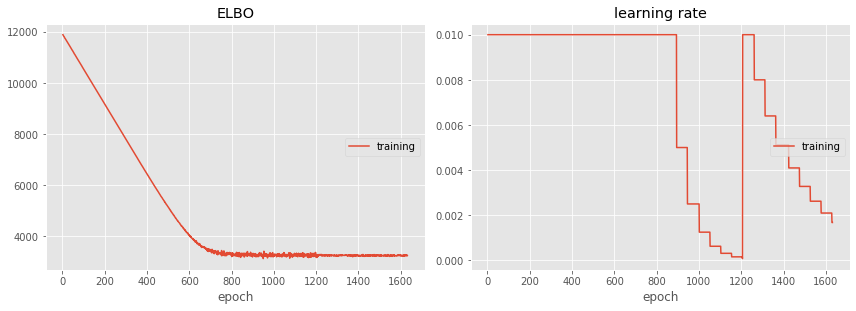

ELBO:
training   (min: 3123.047, max: 11913.583, cur: 3241.588)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.002)


KeyboardInterrupt: 

In [21]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logposterior(z)
    L = (LQ - LP).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        if n_samples_ELBO > 1000:
            break
        else:
            optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.8)
            n_samples_ELBO = n_samples_ELBO*10
        

In [18]:
q.rho.requires_grad = True
q.mu.requires_grad = False

In [22]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

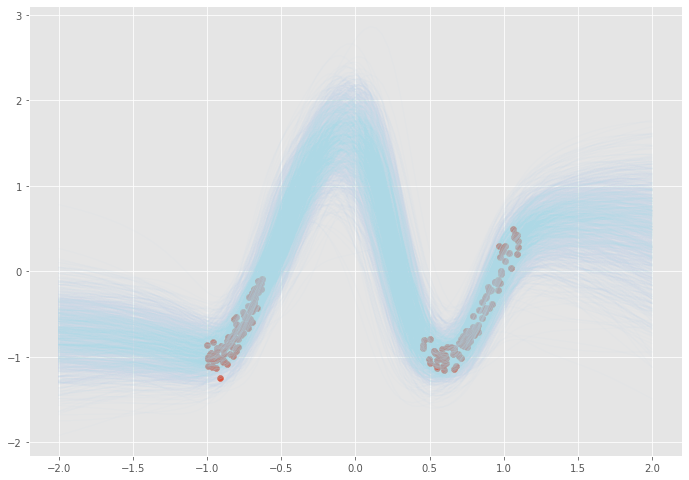

In [23]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = q.sample()
    Net.set_parameters(z)

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')